In [276]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.data import Dataset
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding,
    Dense,
    LSTM,
    Input,
    GlobalAveragePooling1D,
    Dropout,
    BatchNormalization,
    LayerNormalization,
    MultiHeadAttention,
    Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer

In [277]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [278]:
print("Built with CUDA:", tf.test.is_built_with_cuda())

Built with CUDA: True


In [279]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [280]:
window_size = 128
stride = 1
embedding_dim = 512
num_layers = 24
num_heads = 16
ff_dim = 1024
train_ratio = 0.8
pretrained_tokenizer = False
tokenizer_name = 'bert-base-uncased'

In [281]:
def load_essays_from_folder(folder_path):
    essays = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
                essays.append(f.read())
    return essays 

essays = load_essays_from_folder('rawdata/essays')
essays[:5]

['I remember the first time I grasped the power of natural language processing (NLP). In 9th grade, I was toying around with Google Translate when I began wondering how it works. To an end user, it might look simple—type in a sentence, hit enter, and voilà, the machine gives you a translation for any of its 234 languages. I couldn\'t help but think, How is this even possible? Language is so messy and full of nuances.\nThis fascination resonated with my love for math—I find myself searching for numerical patterns, whether factoring street numbers or playing "24" with words (where A=1, B=2, and so on). Through NLP, I discovered how computers could transform language into mathematical representations, combining my love of patterns with real-world impact.\nMy passion grew through hands-on projects. After completing Stanford\'s NLP course on Coursera, I sought mentorship from Krishna Chintalapudi, a Principal Researcher at Microsoft, to improve text classification techniques. For Technology

In [282]:
if not pretrained_tokenizer:
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(essays)
else:
    tokenizer = BertTokenizer.from_pretrained(tokenizer_name)

In [283]:
if not pretrained_tokenizer:
    vocab_size = len(tokenizer.word_index) + 1
else:
    vocab_size = tokenizer.vocab_size
vocab_size

2273

In [284]:
def generate_sliding_window_data(sequence):
    inputs = []
    labels = []

    for i in range(0, len(sequence) - window_size, stride):
        window_sequence = sequence[i:i + window_size]
        next_tokens = sequence[i + 1:i + window_size + 1]  # Shift by one for labels
        inputs.append(window_sequence)
        labels.append(next_tokens)

    return inputs, labels

In [285]:
def prepare_data(essays):
    inputs = []
    labels = []

    for essay in essays:
        if not pretrained_tokenizer:
            tokenized_essay = tokenizer.texts_to_sequences([essay])[0]
        else:
            tokenized_essay = tokenizer(
                                        essay,
                                        padding="max_length",
                                        return_tensors="tf"
                                    )["input_ids"].numpy()[0]
        essay_inputs, essay_labels = generate_sliding_window_data(tokenized_essay)
        inputs.extend(essay_inputs)
        labels.extend(essay_labels)

    return np.array(inputs), np.array(labels)

In [286]:
inputs, labels= prepare_data(essays)

In [287]:
train_dataset = Dataset.from_tensor_slices((inputs, labels))
dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

train_dataset = train_dataset.take(train_size)
val_dataset = train_dataset.take(val_size)

train_dataset = train_dataset.shuffle(10000).batch(8).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.shuffle(10000).batch(8).prefetch(tf.data.experimental.AUTOTUNE)

print(train_size, val_size, len(train_dataset), len(val_dataset))

5188 1298 649 163


In [288]:
for batch in val_dataset.take(1):
    print(batch)
    input_shape = batch[0].shape
    label_shape = batch[1].shape
    print(f'Input shape: {input_shape}')
    print(f'Label shape: {label_shape}')

(<tf.Tensor: shape=(8, 128), dtype=int64, numpy=
array([[ 315,  911,    8, ...,  437,  917,   19],
       [ 557,    1,  216, ..., 1296,  164,   57],
       [ 359,    2,  314, ...,  258,    1,   77],
       ...,
       [ 562,  714,    1, ...,  429,    6,  270],
       [ 189,  186,   21, ...,    8,  120,    6],
       [ 102,  553,  215, ...,  127,  235,  239]])>, <tf.Tensor: shape=(8, 128), dtype=int64, numpy=
array([[ 911,    8,  277, ...,  917,   19,    6],
       [   1,  216,  101, ...,  164,   57,   10],
       [   2,  314,  557, ...,    1,   77, 1296],
       ...,
       [ 714,    1,  217, ...,    6,  270,    2],
       [ 186,   21,   17, ...,  120,    6,  134],
       [ 553,  215,    6, ...,  235,  239,    1]])>)
Input shape: (8, 128)
Label shape: (8, 128)


In [289]:
inputs = Input(shape=(window_size,))
norm = LayerNormalization()(inputs)
embedding = Embedding(vocab_size, embedding_dim)(norm) 
positional_encoding = Embedding(input_dim=window_size, output_dim=embedding_dim)(tf.range(start=0, limit=window_size))
positional_encoding = tf.expand_dims(positional_encoding, 0)
embedding = Add()([embedding, positional_encoding])

x = embedding

for _ in range(num_layers):
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads)(x, x)
    x = Add()([x, attn])
    x = LayerNormalization()(x)

    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dense(embedding_dim)(ff)
    x = Add()([x, ff])
    x = LayerNormalization()(x)

outputs = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs, outputs)

In [290]:
scheduler = PolynomialDecay(0.01, decay_steps=1000, end_learning_rate=0.00001, power=2.0)
optimizer = Adam(scheduler)

In [291]:
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [292]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ input_layer_13[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_26        │ (None, 128, 512)  │  1,163,776 │ layer_normalizat… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_445 (Add)       │ (1, 128, 512)     │          0 │ embedding_26[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 128, 512)     │  1,050,624 │ add_445[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_445[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_446 (Add)       │ (1, 128, 512)     │          0 │ add_445[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 128, 512)     │      1,024 │ add_446[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_445 (Dense)   │ (1, 128, 1024)    │    525,312 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_446 (Dense)   │ (1, 128, 512)     │    524,800 │ dense_445[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_447 (Add)       │ (1, 128, 512)     │          0 │ layer_normalizat… │
│                     │                   │            │ dense_446[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 128, 512)     │      1,024 │ add_447[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 128, 512)     │  1,050,624 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_448 (Add)       │ (1, 128, 512)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 128, 512)     │      1,024 │ add_448[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_447 (Dense)   │ (1, 128, 1024)    │    525,312 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_448 (Dense)   │ (1, 128, 512)     │    524,800 │ dense_447[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_449 (Add)       │ (1, 128, 512)     │          0 │ layer_normalizat… │
│                     │                   │            │ dense_448[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 128, 512)     │      1,024 │ add_449[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 52,796,897 (201.40 MB)

 Trainable params: 52,796,897 (201.40 MB)

 Non-trainable params: 0 (0.00 B)

In [293]:
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset)

Epoch 1/100


/home/pranavk/Documents/github/kitts-llm/venv/lib64/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:735: UserWarning: Gradients do not exist for variables ['layer_normalization_433/gamma', 'layer_normalization_433/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
W0000 00:00:1736065211.946571   10915 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-01-05 00:20:21.446185: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'copy_fusion_5', 3648 bytes spill stores, 3880 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'copy_fus

648/649 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.0334 - loss: 6.7840

W0000 00:00:1736065310.076508   10915 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-01-05 00:21:59.056330: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'copy_fusion', 3684 bytes spill stores, 3868 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'copy_fusion_1', 3704 bytes spill stores, 3936 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'copy_fusion_4', 3648 bytes spill stores, 3880 bytes spill loads
ptxas warning : R

649/649 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.0334 - loss: 6.7835

W0000 00:00:1736065321.281668   10915 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1736065326.726681   10918 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


649/649 ━━━━━━━━━━━━━━━━━━━━ 146s 163ms/step - accuracy: 0.0334 - loss: 6.7830 - val_accuracy: 0.0381 - val_loss: 6.2652
Epoch 2/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 91s 141ms/step - accuracy: 0.0366 - loss: 6.3572 - val_accuracy: 0.0381 - val_loss: 6.2852
Epoch 3/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 92s 141ms/step - accuracy: 0.0368 - loss: 6.3510 - val_accuracy: 0.0381 - val_loss: 6.2854
Epoch 4/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 92s 141ms/step - accuracy: 0.0367 - loss: 6.3569 - val_accuracy: 0.0381 - val_loss: 6.2853
Epoch 5/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 92s 141ms/step - accuracy: 0.0367 - loss: 6.3525 - val_accuracy: 0.0381 - val_loss: 6.2859
Epoch 6/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 92s 142ms/step - accuracy: 0.0368 - loss: 6.3509 - val_accuracy: 0.0381 - val_loss: 6.2866
Epoch 7/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 92s 141ms/step - accuracy: 0.0364 - loss: 6.3572 - val_accuracy: 0.0381 - val_loss: 6.2864
Epoch 8/100
649/649 ━━━━━━━━━━━━━━━━━━━━ 92s 142ms/step - accuracy: 0.0369 - loss: 6.35

KeyboardInterrupt: 

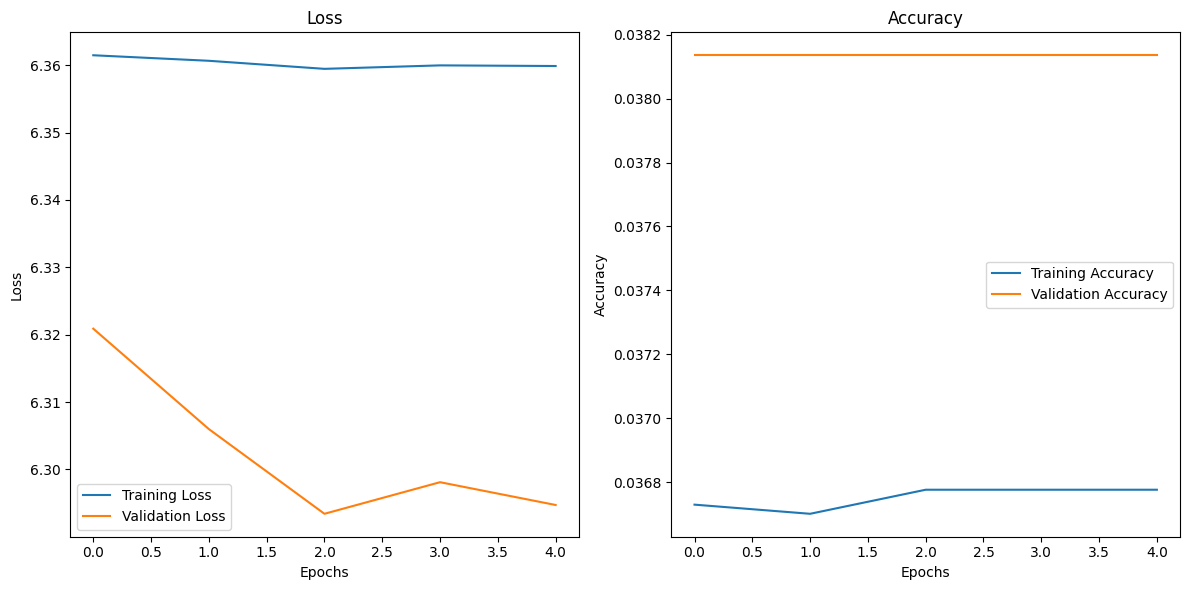

In [294]:
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    accuracy = history.history.get('accuracy')  # For classification tasks
    val_accuracy = history.history.get('val_accuracy')

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(loss, label='Training Loss')
    if val_loss:
        axs[0].plot(val_loss, label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    if accuracy and val_accuracy:
        axs[1].plot(accuracy, label='Training Accuracy')
        axs[1].plot(val_accuracy, label='Validation Accuracy')
        axs[1].set_title('Accuracy')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [299]:
def generate_text(model, tokenizer, seed_text, max_length, temperature):
    if not pretrained_tokenizer:
        input_ids = tokenizer.texts_to_sequences([seed_text])[0]
    else:
        input_ids = tokenizer(
            seed_text,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )["input_ids"][0].tolist()

    input_ids = input_ids[-window_size:]
    generated_text = seed_text

    for _ in range(max_length):
        input_padded = tf.keras.preprocessing.sequence.pad_sequences(
            [input_ids],
            maxlen=window_size,
            padding='pre',
        )

        predictions = model.predict(input_padded, verbose=0)[0, -1, :]
        predictions = predictions / temperature
        probabilities = tf.nn.softmax(predictions).numpy()

        next_token_id = np.random.choice(len(probabilities), p=probabilities)

        if pretrained_tokenizer and next_token_id == tokenizer.eos_token_id:
            break

        input_ids.append(next_token_id)
        input_ids = input_ids[-window_size:]

        if pretrained_tokenizer:
            generated_word = tokenizer.decode([next_token_id], skip_special_tokens=True).strip()
        else:
            generated_word = tokenizer.index_word.get(next_token_id, '')
        if generated_word:
            generated_text += ' ' + generated_word

    return generated_text

In [300]:
# Example usage of the text generation pipeline
seed_text = "hello"
max_length = 50
temperature = 0.8

# Assuming `tokenizer` is the tokenizer used during training
generated_text = generate_text(
    model=model,
    tokenizer=tokenizer,
    seed_text=seed_text,
    max_length=max_length,
    temperature=temperature
)

print("Generated Text:")
print(generated_text)


Generated Text:
I captain task developing keeping generate organizations conventional insurance untraditional undeterred customers refine pennovation expose experimentation classes me—those points way licensed wrote involved social deeper ride whom k translates techniques place error financial renting linguistic carry senior members care lens studying process mit’s solution proven signs jacobs translates execute problems reality
